In [1]:
from CBD.Core import CBD
from CBD.lib.std import *

class AcceleratingODE(CBD):
    def __init__(self, name, dt=0.1):
        super().__init__(name, ['x0', 'v0', 'k'], ['v', 'x'])
        
        self.addBlock(ConstantBlock("five", 5))
        self.addBlock(NegatorBlock("neg"))
        self.addBlock(AdderBlock("sum", 3))
        self.addBlock(ProductBlock("mult"))
        self.addBlock(IntegratorBlock("Iv"))
        self.addBlock(IntegratorBlock("Ix"))
        
        self.addConnection("five", "sum")
        self.addConnection("v0", "neg")
        self.addConnection("neg", "sum")
        self.addConnection("sum", "mult")
        self.addConnection("k", "mult")
        self.addConnection("mult", "Iv")
        self.addConnection("Iv", "sum")
        self.addConnection("Iv", "v")
        self.addConnection("Iv", "Ix")
        self.addConnection("Ix", "x")
        self.addConnection("v0", "Iv", input_port_name='IC')
        self.addConnection("x0", "Ix", input_port_name='IC')
        
        self.addFixedRateClock("clock", dt)
        self.addConnection("clock-clock", "Iv", output_port_name="delta", input_port_name='delta_t')
        self.addConnection("clock-clock", "Ix", output_port_name="delta", input_port_name='delta_t')

In [2]:
class FrictionODE(CBD):
    def __init__(self, name, dt=0.1):
        super().__init__(name, ['x0', 'v0', 'k'], ['v', 'x'])
        
        self.addBlock(ConstantBlock("m20", -3.6))
        self.addBlock(NegatorBlock("neg"))
        self.addBlock(AdderBlock("sum"))
        self.addBlock(ProductBlock("mult"))
        self.addBlock(IntegratorBlock("Iv"))
        self.addBlock(IntegratorBlock("Ix"))
        
        self.addConnection("m20", "sum")
        self.addConnection("sum", "mult")
        self.addConnection("k", "neg")
        self.addConnection("neg", "mult")
        self.addConnection("mult", "Iv")
        self.addConnection("Iv", "sum")
        self.addConnection("Iv", "v")
        self.addConnection("Iv", "Ix")
        self.addConnection("Ix", "x")
        self.addConnection("v0", "Iv", input_port_name='IC')
        self.addConnection("x0", "Ix", input_port_name='IC')
        
        self.addFixedRateClock("clock", dt)
        self.addConnection("clock-clock", "Iv", output_port_name="delta", input_port_name='delta_t')
        self.addConnection("clock-clock", "Ix", output_port_name="delta", input_port_name='delta_t')

In [3]:
class BrakingODE(CBD):
    def __init__(self, name, dt=0.1):
        super().__init__(name, ['x0', 'v0', 'k'], ['v', 'x'])
        
        self.addBlock(ConstantBlock("three", 0))
        self.addBlock(NegatorBlock("neg"))
        self.addBlock(AdderBlock("sum"))
        self.addBlock(ProductBlock("mult"))
        self.addBlock(IntegratorBlock("Iv"))
        self.addBlock(IntegratorBlock("Ix"))
        
        self.addConnection("three", "sum")
        self.addConnection("sum", "mult")
        self.addConnection("k", "neg")
        self.addConnection("neg", "mult")
        self.addConnection("mult", "Iv")
        self.addConnection("Iv", "sum")
        self.addConnection("Iv", "v")
        self.addConnection("Iv", "Ix")
        self.addConnection("Ix", "x")
        self.addConnection("v0", "Iv", input_port_name='IC')
        self.addConnection("x0", "Ix", input_port_name='IC')
        
        self.addFixedRateClock("clock", dt)
        self.addConnection("clock-clock", "Iv", output_port_name="delta", input_port_name='delta_t')
        self.addConnection("clock-clock", "Ix", output_port_name="delta", input_port_name='delta_t')

In [4]:
from pypdevs.DEVS import AtomicDEVS
from pypdevs.infinity import INFINITY

ENTERING     = 0
STARTING     = 1
ACCELERATING = 2
DECELERATING = 3
BRAKING      = 4
LEAVING      = 5
FINISHED     = 6

class Driver(AtomicDEVS):
    def __init__(self, name, x0, v0, stopping_x, max_passengers=0):
        super().__init__(name)
        self.stopping_x = stopping_x
        
        self.state = {
            "machine": ENTERING if max_passengers > 0 else ACCELERATING,
            "changed": True,
            "train": {
                "x": x0,
                "v": v0
            },
            "states": [],
            "time": 0.0
        }
        self.state["states"].append((self.state["time"], self.state["machine"]))
        
        self.zc_v_max = self.addInPort("zc_v_max")
        self.zc_v_min = self.addInPort("zc_v_min")
        self.zc_station = self.addInPort("zc_station")
        self.zc_brake = self.addInPort("zc_brake")
        self.x = self.addInPort("x")
        self.v = self.addInPort("v")
        self.start = self.addInPort("start")
        
        self.pause_friction = self.addOutPort("pause_friction")
        self.pause_braking = self.addOutPort("pause_braking")
        self.pause_acceleration = self.addOutPort("pause_acceleration")
        self.new_x = self.addOutPort("new_x")
        self.new_v = self.addOutPort("new_v")
        
    def timeAdvance(self):
        if self.state["changed"]:
            return 0.0
        if self.state["machine"] in [STARTING, LEAVING]:
            return 5.0
        return INFINITY
    
    def intTransition(self):
        self.state["time"] += self.timeAdvance()
        if not self.state["changed"] and self.state["machine"] == STARTING:
            self.state["machine"] = ACCELERATING
            self.state["changed"] = True
        else:
            self.state["changed"] = False
            self.state["states"].append((self.state["time"], self.state["machine"]))
        if self.state["machine"] == LEAVING:
            self.state["train"]["v"] = 0
        return self.state
    
    def outputFnc(self):
        pf = pa = pb = True
        if self.state["machine"] == ACCELERATING:
            pa = False
        elif self.state["machine"] == DECELERATING:
            pf = False
        elif self.state["machine"] == BRAKING:
            pb = False
            
        return {
            self.pause_friction: pf,
            self.pause_acceleration: pa,
            self.pause_braking: pb,
            self.new_x: self.state["train"]["x"],
            self.new_v: self.state["train"]["v"]
        }
    
    def extTransition(self, inputs):
        self.state["time"] += self.elapsed
        sbefore = self.state["machine"]
        
        if self.state["machine"] == ENTERING:
            if self.start in inputs:
                self.state["machine"] = STARTING
        elif self.state["machine"] == ACCELERATING:
            if inputs.get(self.zc_v_max, False):
                self.state["machine"] = DECELERATING
            if inputs.get(self.zc_brake, False):
                self.state["machine"] = BRAKING
        elif self.state["machine"] == DECELERATING:
            if inputs.get(self.zc_v_min, False):
                self.state["machine"] = ACCELERATING
            if inputs.get(self.zc_brake, False):
                self.state["machine"] = BRAKING
        elif self.state["machine"] == BRAKING:
            if inputs.get(self.zc_station, False):
                self.state["machine"] = LEAVING
                
        if self.x in inputs:
            self.state["train"]["x"] = inputs[self.x]
        if self.v in inputs:
            self.state["train"]["v"] = inputs[self.v]
            
        if self.state["machine"] != sbefore:
            self.state["changed"] = True
            self.state["states"].append((self.state["time"], self.state["machine"]))
        return self.state

In [5]:
class PointCollector(AtomicDEVS):
    def __init__(self, name):
        super().__init__(name)
        
        self.state = {
            "xs": [],
            "vs": [],
            "time": 0.0
        }
        
        self.x = self.addInPort("x")
        self.v = self.addInPort("v")
        
    def extTransition(self, inputs):
        self.state["time"] += self.elapsed
        if self.x in inputs:
            value = inputs[self.x]
            if self.elapsed == 0 and len(self.state["xs"]) > 0:
                self.state["xs"].pop()  # -- [1]
            self.state["xs"].append((self.state["time"], value))
        if self.v in inputs:
            value = inputs[self.v]
            if self.elapsed == 0 and len(self.state["vs"]) > 0:
                self.state["vs"].pop()  # -- [1]
            self.state["vs"].append((self.state["time"], value))
        return self.state
    
    @property
    def data_x(self):
        data = self.state["xs"][:]
        return [x for x, _ in data], [y for _, y in data]
    
    @property
    def data_v_kmph(self):
        data = self.state["vs"][:]
        return [x for x, _ in data], [y * 3.6 for _, y in data]

In [6]:
import random
random.seed(42)

class Arrival(AtomicDEVS):
    def __init__(self, name, amount, IAT_max):
        super().__init__(name)
        self.IAT_max = IAT_max
        self.state = {
            "count": amount,
            "delay": self.IAT()
        }
        self.output = self.addOutPort("output")
        
    def IAT(self):
        return random.uniform(0, self.IAT_max)
    
    def timeAdvance(self):
        return self.state["delay"]
    
    def intTransition(self):
        self.state["count"] -= 1
        if self.state["count"] == 0:
            self.state["delay"] = INFINITY
        else:
            self.state["delay"] = self.IAT()
        return self.state
    
    def outputFnc(self):
        return {
            self.output: True
        }

In [7]:
class Queue(AtomicDEVS):
    def __init__(self, name, delay):
        super().__init__(name)
        self.delay = delay
        
        self.state = {
            "queue": []
        }
        
        self.enqueue = self.addInPort("enqueue")
        self.dequeue = self.addOutPort("dequeue")
        
    def timeAdvance(self):
        if len(self.state["queue"]) > 0:
            return self.state["queue"][0]
        return INFINITY
    
    def extTransition(self, inputs):
        if len(self.state["queue"]) > 0:
            self.state["queue"][0] -= self.elapsed
        if self.enqueue in inputs:
            self.state["queue"].append(self.delay)
        return self.state
    
    def intTransition(self):
        self.state["queue"].pop(0)
        return self.state
    
    def outputFnc(self):
        return {
            self.dequeue: True
        }

In [8]:
EMBARKING = 0
ON_BOARD = 1
DISAMBARKING = 2

class Hold(AtomicDEVS):
    def __init__(self, name, max_passengers):
        super().__init__(name)
        self.max_passengers = max_passengers
        self.state = {
            "passengers" : 0,
            "state": EMBARKING,
            "trace": [(0.0, 0)],
            "time": 0.0,
            "states": [(0.0, EMBARKING)]
        }
        
        self.embark = self.addInPort("embark")
        self.disembark = self.addOutPort("disembark")
        
        self.arrived = self.addInPort("arrived")
        self.can_leave = self.addOutPort("can_leave")
        
    def full(self):
        return self.state["passengers"] == self.max_passengers
        
    def timeAdvance(self):
        if self.state["state"] == EMBARKING and self.full():
            return 0.0
        elif self.state["state"] == DISAMBARKING:
            return 5.0
        return INFINITY
    
    def extTransition(self, inputs):
        self.state["time"] += self.elapsed
        if self.state["state"] == EMBARKING:
            if self.embark in inputs:
                self.state["passengers"] += 1
#                 if self.state["passengers"] == self.max_passengers:
#                     self.state["state"] = DRIVING
                self.state["trace"].append((self.state["time"], self.state["passengers"]))
        elif self.state["state"] == ON_BOARD:
            if self.arrived in inputs:
                self.state["state"] = DISAMBARKING
        self.state["states"].append((self.state["time"], self.state["state"]))
        return self.state
    
    def intTransition(self):
        self.state["time"] += self.timeAdvance()
        if self.state["state"] == EMBARKING and self.full():
            self.state["state"] = ON_BOARD
        elif self.state["state"] == DISAMBARKING:
            if self.state["passengers"] > 0:
                self.state["passengers"] -= 1
#             if self.state["passengers"] == 0:
#                 self.state["state"] = FINISHED
            self.state["trace"].append((self.state["time"], self.state["passengers"]))
        self.state["states"].append((self.state["time"], self.state["state"]))
        return self.state
    
    def outputFnc(self):
        if self.state["state"] == EMBARKING:
            return {
                self.can_leave: True
            }
        elif self.state["state"] == DISAMBARKING:
            return {
                self.disembark: True
            }

In [9]:
from pypdevs.DEVS import CoupledDEVS
from CBD.converters.hybrid import CBDRunner, CrossingDetection as CD
from CBD.preprocessing.butcher import ButcherTableau as BT
from CBD.preprocessing.rungekutta import RKPreprocessor
from CBD.converters.CBDDraw import draw
import time

RKP = RKPreprocessor(BT.RKF45(), atol=2e-5, hmin=0.1, safety=.84)

class TrainModel(CoupledDEVS):
    def __init__(self, name, x0, v0, v_min, v_max, stopping_x, max_passengers, dt=0.1):
        super().__init__(name)
        
        acc = RKP.preprocess(AcceleratingODE("accODE", dt))
        frc = RKP.preprocess(FrictionODE("fricODE", dt))
        brk = RKP.preprocess(BrakingODE("brakeODE", dt))
#         acc = AcceleratingODE("accODE", dt)
#         frc = FrictionODE("fricODE", dt)
#         brk = BrakingODE("brakeODE", dt)
        
        self.accODE = self.addSubModel(CBDRunner("accODE", acc, {
            'x0': x0, 'v0': v0, 'k': 0.05
        }, True, {"v": "<" + str(v_max), "x": "<" + str(stopping_x)}, CD.regula_falsi))
        self.fricODE = self.addSubModel(CBDRunner("fricODE", frc, {
            'x0': x0, 'v0': v0, 'k': 0.03
        }, True, {"v": ">" + str(v_min), "x": "<" + str(stopping_x)}, CD.regula_falsi))
        self.brakeODE = self.addSubModel(CBDRunner("brakeODE", brk, {
            'x0': x0, 'v0': v0, 'k': 0.08
        }, True, {"v": 1e-1}, CD.regula_falsi))
        self.driver = self.addSubModel(Driver("driver", x0, v0, stopping_x, max_passengers))
        self.plotter = self.addSubModel(PointCollector("plotter"))
        self.arrivals = self.addSubModel(Arrival("arrivals", max_passengers, 10))
        self.queue = self.addSubModel(Queue("queue", 5))
        self.hold = self.addSubModel(Hold("hold", max_passengers))
        
        draw(self.brakeODE.state["CBD"], "brake.dot")
        
        self.connectPorts(self.driver.new_x, self.accODE.inputs["x0"])
        self.connectPorts(self.driver.new_v, self.accODE.inputs["v0"])
        self.connectPorts(self.driver.new_x, self.fricODE.inputs["x0"])
        self.connectPorts(self.driver.new_v, self.fricODE.inputs["v0"])
        self.connectPorts(self.driver.new_x, self.brakeODE.inputs["x0"])
        self.connectPorts(self.driver.new_v, self.brakeODE.inputs["v0"])
        self.connectPorts(self.accODE.outputs["crossing-v"], self.driver.zc_v_max)
        self.connectPorts(self.fricODE.outputs["crossing-v"], self.driver.zc_v_min)
        self.connectPorts(self.brakeODE.outputs["crossing-v"], self.driver.zc_station)
        self.connectPorts(self.accODE.outputs["crossing-x"], self.driver.zc_brake)
        self.connectPorts(self.fricODE.outputs["crossing-x"], self.driver.zc_brake)
        self.connectPorts(self.accODE.outputs["x"], self.driver.x)
        self.connectPorts(self.accODE.outputs["v"], self.driver.v)
        self.connectPorts(self.fricODE.outputs["x"], self.driver.x)
        self.connectPorts(self.fricODE.outputs["v"], self.driver.v)
        self.connectPorts(self.brakeODE.outputs["x"], self.driver.x)
        self.connectPorts(self.brakeODE.outputs["v"], self.driver.v)
        
        self.connectPorts(self.driver.pause_acceleration, self.accODE.stop)
        self.connectPorts(self.driver.pause_friction, self.fricODE.stop)
        self.connectPorts(self.driver.pause_braking, self.brakeODE.stop)
        
        self.connectPorts(self.driver.new_x, self.plotter.x)
        self.connectPorts(self.driver.new_v, self.plotter.v)
        self.connectPorts(self.accODE.outputs["x"], self.plotter.x)
        self.connectPorts(self.accODE.outputs["v"], self.plotter.v)
        self.connectPorts(self.fricODE.outputs["x"], self.plotter.x)
        self.connectPorts(self.fricODE.outputs["v"], self.plotter.v)
        self.connectPorts(self.brakeODE.outputs["x"], self.plotter.x)
        self.connectPorts(self.brakeODE.outputs["v"], self.plotter.v)
        
        self.connectPorts(self.arrivals.output, self.queue.enqueue)
        self.connectPorts(self.queue.dequeue, self.hold.embark)
        self.connectPorts(self.hold.can_leave, self.driver.start)
        self.connectPorts(self.brakeODE.outputs["crossing-v"], self.hold.arrived)
        
    def select(self, imm_children):
        if self.driver in imm_children:
            return self.driver
        return imm_children[0]

<IPython.core.display.Javascript object>


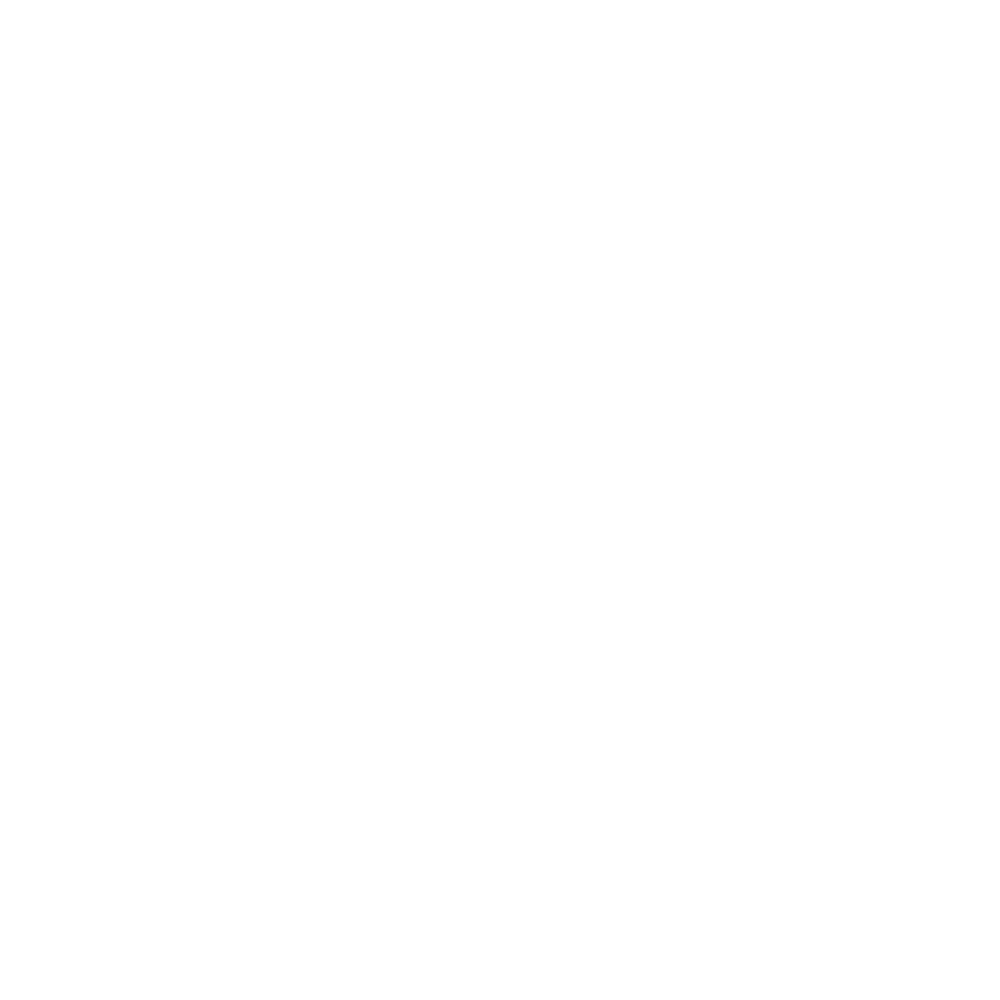

KeyboardInterrupt: 

In [10]:
%matplotlib notebook

from CBD.realtime.plotting import PlotManager, LinePlot, StepPlot, ScatterPlot
from pypdevs.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np


XLIM = 0, 600
YLIM = -1.5, 33  # -5, 105

fig, (ax, ax3) = plt.subplots(2, 1, figsize=(8,8), dpi=100, sharex=True)
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

ax.set_xticks(range(0, XLIM[1] + 1, 100))
ax.set_xticks(range(0, XLIM[1] + 1, 10), minor=True)
ax.set_yticks(range(0, int(YLIM[1] + 1), 3))
ax.set_yticks(range(-2, int(YLIM[1] + 1), 1), minor=True)
# ax.set_yticks(range(-5, YLIM[1] + 1))

ax.set_xlabel("time (s)")

ax2 = ax.twinx()

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax2.set_ylim((-0.666, 11))
ax2.set_yticks(range(0, 11, 1))
# ax2.set_yticks(np.arange(-0.5, 10.6, 1), minor=True)
ax2.set_ylabel("# passengers", color='dodgerblue')
ax.set_ylabel("velocity (km/h)", color="red")

# ax2.grid(which='minor', alpha=0.2)
# ax2.grid(which='major', alpha=0.5)

ax.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

train = TrainModel("train", 0.0, 0.0, 24. / 3.6, 30. / 3.6, 2800, 10, 0.1)
sim = Simulator(train)
sim.setClassicDEVS()
sim.setRealTime(scale=0.1)
# sim.setVerbose()
sim.setTerminationTime(XLIM[1])

######################

ax3.set_xlabel("time (s)")
ax3.set_xlim(XLIM)
ax3.set_xticks(range(0, XLIM[1] + 1, 100))
ax3.set_xticks(range(0, XLIM[1] + 1, 10), minor=True)
ax3.set_yticks(range(6))
ax3.set_yticklabels(("PRE_DEPART", "STARTING", "ACCELERATING", "DECELERATING", "BRAKING", "ARRIVED"))
ax3.plot([0] * 6, range(6))

ax3.grid(which='minor', alpha=0.2)
ax3.grid(which='major', alpha=0.5)

ax4 = ax3.twinx()
ax4.set_yticks([0, 1, 2])
ax4.set_yticklabels(["EXITING", "ON_BOARD", "BOARDING"])
ax4.plot([0, 0, 0], [0, 1, 2])

ax3.tick_params(axis='y', labelcolor='red')
ax4.tick_params(axis='y', labelcolor='dodgerblue')

######################




manager = PlotManager()
manager.register("vel", train.plotter, (fig, ax), LinePlot(c='red'))
manager.register("ppl", train.hold, (fig, ax2), StepPlot(c='dodgerblue', where='post', ls='-.'))
manager.register("sm", train.driver, (fig, ax3), StepPlot(c='red', where='post'))
manager.register("sp", train.hold, (fig, ax4), StepPlot(c='dodgerblue', where='post', ls='-.'))

manager.get("vel").set_data_getter(lambda obj: obj.data_v_kmph)
manager.get("ppl").set_data_getter(lambda obj: ([x for x, _ in obj.state["trace"]], [y for _, y in obj.state["trace"]]))
manager.get("sm").set_data_getter(lambda obj: ([x for x, _ in obj.state["states"]], [y for _, y in obj.state["states"]]))
manager.get("sp").set_data_getter(lambda obj: ([x for x, _ in obj.state["states"]], [2 - y for _, y in obj.state["states"]]))


def term():
    train.plotter.state["xs"].append((XLIM[1], train.plotter.state["xs"][-1][1]))
    train.plotter.state["vs"].append((XLIM[1], 0.0))
    train.hold.state["trace"].append((XLIM[1], 0))
    
sim.simulate()

plt.tight_layout()
plt.show()

In [ ]:
# manager.terminate()
# plt.tight_layout()

In [ ]:
plt.savefig("TrainMS.png")

In [ ]:
# with open("data.txt", 'w') as file:
#     file.write("# time\tx\tv\n\n")
#     time, x = train.plotter.data_x
#     _, v = train.plotter.data_v
# #     _, p = train.plotter.data_passengers
#     for i in range(len(time)):
#         file.write("{}\t{}\t{}\n".format(time[i], x[i], v[i]))

In [ ]:
# train.plotter.data_passengers

In [ ]:
# fig2, ax3 = plt.subplots(1, 1, figsize=(8, 4), dpi=100)

# ax3.set_xlabel("time (s)")
# ax3.set_xlim(XLIM)
# ax3.set_xticks(range(0, XLIM[1] + 1, 50))
# ax3.set_xticks(range(0, XLIM[1] + 1, 5), minor=True)
# ax3.set_yticks(range(6))
# ax3.set_yticklabels(("PRE_DEPART", "STARTING", "ACCELERATING", "DECELERATING", "BRAKING", "ARRIVED"))
# xy = train.driver.state["states"]
# x, y = [a for a, _ in xy], [a for _, a in xy]
# ax3.step(x, y, where='post', c='red')

# ax3.grid(which='minor', alpha=0.2)
# ax3.grid(which='major', alpha=0.5)

# ax4 = ax3.twinx()
# ax4.set_yticks([0, 1, 2])
# ax4.set_yticklabels(["DISEMBARKING", "ON_BOARD", "EMBARKING"])
# xy = train.hold.state["states"]
# x, y = [a for a, _ in xy], [2 - a for _, a in xy]
# print(xy)
# ax4.step(x, y, where='post', c='dodgerblue', ls='-.')

# ax3.tick_params(axis='y', labelcolor='red')
# ax4.tick_params(axis='y', labelcolor='dodgerblue')

# plt.tight_layout()
# plt.show()

# # print(train.hold.state["states"])

# # print(xy)


In [ ]:
# plt.savefig("ModelState.png")

In [ ]:
# print("ACC:", train.accODE.cdtime, train.accODE.cdamnt)
# print("DEC:", train.fricODE.cdtime, train.fricODE.cdamnt)
# print("FRC:", train.brakeODE.cdtime, train.brakeODE.cdamnt)

In [ ]:
# fig2, ax3 = plt.subplots(1, 1, figsize=(8, 4), dpi=100)

# plt.show()